# Homework 2: Sentiment analysis


In this homework, you'll build several classifiers that can predict a user's rating of a movie solely from the words of their review. This is called **sentiment analysis**. 

We'll start with some simple non-neural classifiers before moving to a neural network implementation. 

We'll also see how transformers perform on this task. 

Throughout the assignment, we'll explore a few different ways to encode the text data and assess an encoding's impact on model performance. 

The dataset we'll be using is the Rotten Tomatoes dataset. We've downloaded it for you, but if you want to find out where we got it from you can check out this link: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews.

## import library

In [1]:
! pip install -U spacy -q
! python -m spacy download en_core_web_md -q
! pip install transformers -q 

2023-04-23 02:27:13.152198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 02:27:16.745050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
import spacy
import en_core_web_md
import torch
from torch.utils.data import random_split, Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import Vocab
from transformers import BertTokenizer, BertModel

import time
import os 
from collections import Counter 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch version is: ", torch.__version__)
print("You are using: ", device)

Pytorch version is:  2.0.0+cu118
You are using:  cpu


## Part A: dataset exploration

### Data preprocessing


The dataset is in the file **train.tsv** (even though the file is called train.tsv, this is the entire dataset that we want you to use). We have written a line of code to load up the dataset from the directory where you stored the file into a pandas DataFrame (check out the documentation [here](https://pandas.pydata.org/docs/reference/frame.html) if you've never used pandas before). This variable is called `all_raw`.

The dataframe `all_raw` currently has the columns `PhraseId`, `SentenceId`, `Phrase` and `Sentiment`. We're going to outline a few preprocessing steps that you need to take to get the data in the right form for classification. Name your processed dataframe variable `all_data`. 

**Step 1**: There are several reviews with duplicated `SentenceId` (subphrases of the full review). Write some code to keep only the first phrase for any given `SentenceId` in your dataframe. Then you can drop the `PhraseId` and `SentenceId` columns. Rename the column called `Phrase` to `text`.

**Step 2**: The next preprocessing step is to convert the values in the `Sentiment` column to a binary encoding (Boolean values) that represents whether the review is good (rating of 3 or 4) or bad (rating of 0, 1 or 2). **Keep the original `Sentiment` column**, renaming it `rating`, and title your binary encoding column `is_good`.

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/train.tsv' # TODO: replace this with your own path to the dataset (should end in train.tsv)
all_raw = pd.read_table(data_path)
# Step 1: Sort the DataFrame by SentenceId and PhraseId
all_data = all_raw.sort_values(['SentenceId', 'PhraseId'])

# Group by SentenceId and keep the first record for each group
all_data = all_data.groupby('SentenceId').first().reset_index()

# Drop PhraseId and SentenceId columns
all_data = all_data.drop(['PhraseId', 'SentenceId'], axis=1)

# Rename the column 'Phrase' to 'text'
all_data = all_data.rename(columns={'Phrase': 'text'})

# step 2
# Rename the Sentiment column to rating
all_data = all_data.rename(columns={'Sentiment': 'rating'})

# Create a new column is_good, setting it to True if the rating is 3 or 4, and False otherwise
all_data['is_good'] = all_data['rating'].apply(lambda x: x >= 3)
# ## TODO: write code for steps 1 and 2 above

# Tests to ensure your columns are labelled correctly and contain the right content
assert 'is_good' in all_data.columns
assert 'text' in all_data.columns
assert 'rating' in all_data.columns
assert sum(all_data.text.apply(lambda x: len(x))) == 868869

In [6]:
all_data 

,text,rating,is_good
0,A series of escapades demonstrating the adage ...,1,False
1,"This quiet , introspective and entertaining in...",4,True
2,"Even fans of Ismail Merchant 's work , I suspe...",1,False
3,A positively thrilling combination of ethnogra...,3,True
4,Aggressive self-glorification and a manipulati...,1,False
...,...,...,...
8524,... either you 're willing to go with this cla...,2,False
8525,"Despite these annoyances , the capable Claybur...",2,False
8526,-LRB- Tries -RRB- to parody a genre that 's al...,1,False
8527,The movie 's downfall is to substitute plot fo...,1,False


### Exploring the dataset



Make up to 5 plots that show some relationships between the text of the review and the sentiment (you can use both the 0-4 rating in the `rating` column and the binary rating in the `is_good` column, though ultimately we'll only be using the binary rating). 

Some things you may wish to explore are whether the length of the review has any bearing on the sentiment, how many good and bad reviews there are, etc. 

In the text cell below, comment on what you've found and whether this matches your intuitions about movie reviews more generally.

We've imported matplotlib.pyplot and seaborn for your convenience.

In [ ]:
# TODO: make some plots that show some patterns in the dataset!

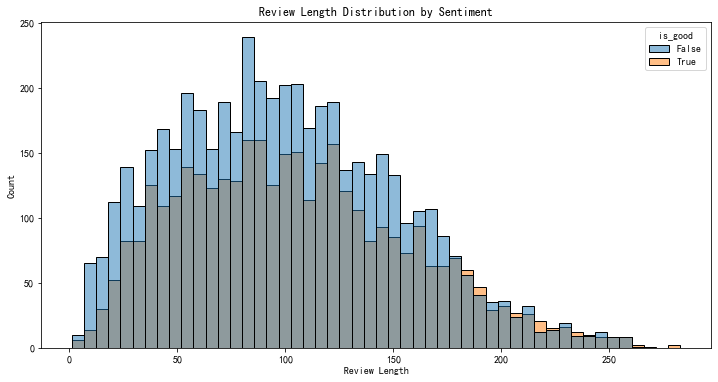

In [ ]:
# Create a new column with the length of each review
all_data['review_length'] = all_data['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=all_data, x='review_length', hue='is_good', bins=50)
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()


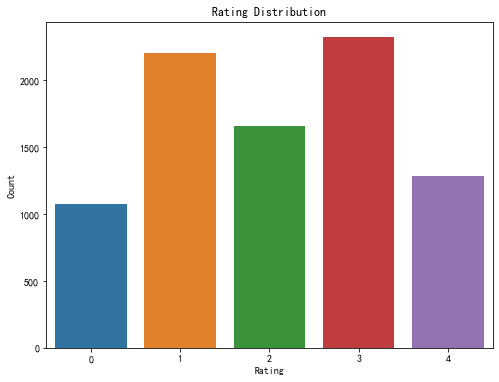

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=all_data, x='rating')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


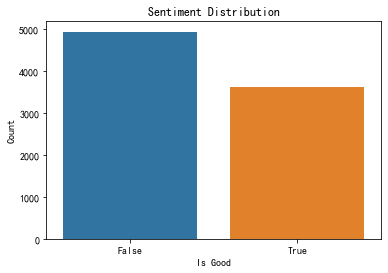

In [ ]:
# plt.figure(figsize=(8, 6))
sns.countplot(data=all_data, x='is_good')
plt.title('Sentiment Distribution')
plt.xlabel('Is Good')
plt.ylabel('Count')
plt.show()


**TODO: write your observations about the plots here.**

### Bag of words encoding
**Step 1**: Print out the number of unique tokens in your dataset. You should use the `word_tokenize` function from NLTK (imported).

In [ ]:
## TODO: count the number of unique tokens 
all_text = ' '.join(all_data['text'].str.lower())  # Combine all texts into a single string
tokens = nltk.word_tokenize(all_text)  # Tokenize the text
vocab = set(tokens)
vocab_size = len(vocab)
vocab_size

16431

**Step 2**: Convert the text of each review to a bag-of-words encoding. You should use a vocabulary size that is the minimum of 2001 and the number of tokens you calculated in the cell above.

The number 2001 corresponds to the 2000 most common tokens and an extra one for any words that do not match those tokens (think of these like the `RARE_WORDS` from Homework 1). 

In [ ]:
RARE_TOKEN = '_rare_'
top2k_tokens =  [token for token, count in FreqDist(tokens).most_common(min(2000, vocab_size))]
vocab = top2k_tokens + [RARE_TOKEN]

# Create a custom tokenizer that replaces rare words with RARE_TOKEN
def custom_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    return [token if token in top2k_tokens else RARE_TOKEN for token in tokens]

# Initialize the CountVectorizer with the custom tokenizer and vocabulary
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, vocabulary=vocab)

# Fit and transform the text data into a bag-of-words matrix
bow_matrix = vectorizer.fit_transform(all_data['text'])

# Convert the matrix to a DataFrame for better visualization
data = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the bag-of-words encoding DataFrame
data 

,.,the,",",a,and,of,to,is,'s,it,...,abstract,capture,attractive,whimsical,saga,notion,gangs,abandon,credible,_rare_
0,1,3,1,2,0,4,1,2,0,0,...,0,0,0,0,0,0,0,0,0,6
1,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
2,1,0,2,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
3,1,1,2,3,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8524,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8525,1,3,1,1,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8526,1,1,0,2,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,2
8527,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,2


## Part B: Machine learning

### logistic regression


**Step 1**: Use your bag of words encoding to train a logistic regression model that predicts whether a review is good or bad. Train the model on 80% of your dataset and print the accuracy score for both your training and testing data.

We've imported the `LogisticRegression` model from scikit-learn function for your convenience. Use the scikit-learn `train_test_split` function (also imported) to split your dataset into training and testing; set the `random_state` to 1.

In [ ]:
# TODO: train your logistic regression model
X_train, X_test, y_train, y_test = train_test_split(data, all_data['is_good'], test_size=0.2, random_state=1)
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
train_acc, test_acc 


(0.8670672724607944, 0.7420867526377491)

**Step 2**: We're going to see which words were most important to the model. Print out the words that correspond to the 20 coefficients in the logistic regression model with the highest absolute value. (To get the coefficients for the model you trained, you can use `model.coef_`.)

In [ ]:
# TODO: print out top 20 features of logistic regression model
top20_idx = np.argsort(np.abs(model.coef_[0]))[::-1][:20]
top20_tokens = data.columns.to_numpy()[top20_idx]
top20_coeff = model.coef_[0][top20_idx]
top20_tokens

array(['remarkable', 'worst', 'definitely', 'suffers', 'refreshing',
       'mess', 'bland', 'lack', 'stupid', 'wonderfully', 'solid',
       'charmer', 'delivers', 'eyes', 'warm', 'treat', 'lacking',
       'summer', 'wonderful', 'unfunny'], dtype=object)

**Step 3**: Plot these 20 coefficients (with their original sign) in a bar plot. Label each bar with the word to which it corresponds. What do you notice about the relationship between the words and the bars? Add your observation in the text cell below.

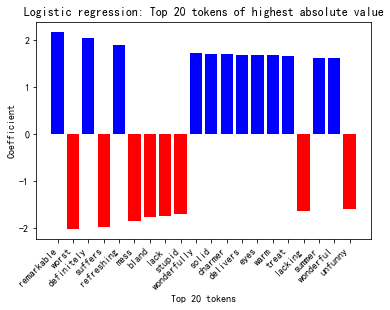

In [ ]:
# TODO: plot the top 20 coefficients
fig = plt.figure()
ax = fig.add_subplot()
bar_colors = ['red' if c < 0 else 'blue' for c in top20_coeff]
plt.bar(top20_tokens, top20_coeff, color=bar_colors)
plt.title("Logistic regression: Top 20 tokens of highest absolute value")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel("Coefficient")
plt.xlabel("Top 20 tokens")
plt.show()

**TODO: write your observations here**

positive tokens have positive coefficients while negative tokens have negative coefficients

### knn, Naive Bayes, SVM



Run the classification again using three different models: **K-nearest Neighbors (with 5 neighbors)**, **Gaussian Naive Bayes** and **Support Vector Classifier**. 

All of these have been imported from scikit-learn. 

Which model performed best? 

Can you speculate why this was the case? You may provide feature importance plots/figures where appropriate.

In [ ]:
# TODO: do the same thing with other models and see whether they perform any better
model1 = KNeighborsClassifier(n_neighbors=5)
model2 = GaussianNB()
model3 = SVC(kernel='linear')
models = [model1, model2, model3]
metrics = {}
for model in models:
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    metrics[model.__class__.__name__] = {'train_acc': train_acc, 'test_acc': test_acc}

metrics 

/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

{'KNeighborsClassifier': {'train_acc': 0.7172797889491426,
  'test_acc': 0.5849941383352872},
 'GaussianNB': {'train_acc': 0.7183057306170306,
  'test_acc': 0.6207502930832356},
 'SVC': {'train_acc': 0.8792320093800381, 'test_acc': 0.7245017584994138}}

**TODO: which model was best and why?**

SVM performs best

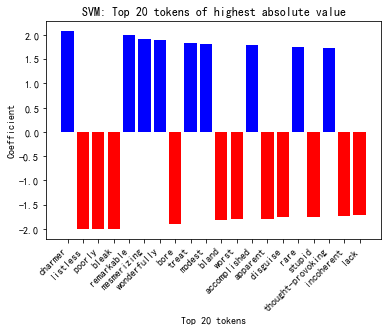

In [ ]:
# TODO: print out top 20 features of logistic regression model
top20_idx = np.argsort(np.abs(model.coef_[0]))[::-1][:20]
top20_tokens = data.columns.to_numpy()[top20_idx]
top20_coeff = model.coef_[0][top20_idx]
fig = plt.figure()
ax = fig.add_subplot()
bar_colors = ['red' if c < 0 else 'blue' for c in top20_coeff]
plt.bar(top20_tokens, top20_coeff, color=bar_colors)
plt.title("SVM: Top 20 tokens of highest absolute value")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel("Coefficient")
plt.xlabel("Top 20 tokens")
plt.show()

### PCA


Our reviews are currently encoded in a form with thousands of features. This is potentially slowing down the runtime of our models. However, we can use dimensionality reduction techniques such as **Principal Component Analysis (PCA)** to capture the majority of the variance that we observe in our encodings but with far fewer dimensions needed.

Use PCA to perform dimensionality reduction on the bag-of-words encodings. Then train a logistic regression model using these reduced vectors. Try this on different numbers of principal components; we have provided these in the code. We have imported the PCA implementation from scikit-learn for your convenience. (Hint: the `fit_transform` function might be useful.)

Plot the test performance of your different encodings in a bar plot. How does the performance of the reduced vectors compare with the original?

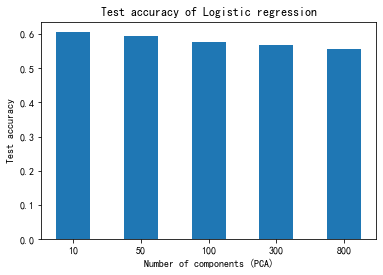

In [ ]:
n_components = [10, 50, 100, 300, 800]

# TODO: perform PCA on bag of words using the numbers of components above and explore how this affects logistic regression model performance
test_accs = []
for n in n_components:
    pca = PCA(n_components=n)
    # YOUR CODE HERE
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.fit_transform(X_test)
    model = LogisticRegression(max_iter=1000).fit(X_train_reduced, y_train)
    test_acc = model.score(X_test_reduced, y_test)
    test_accs.append(test_acc)

fig = plt.figure()
ax = fig.add_subplot()
plt.bar(range(len(n_components)), test_accs, width=0.5)
ax.set_xticks(range(len(n_components)))  # Set the x-tick positions
ax.set_xticklabels(n_components)  # Set the x-tick labels
plt.title("Test accuracy of Logistic regression")
plt.ylabel("Test accuracy")
plt.xlabel("Number of components (PCA)")
plt.show()

**TODO: how do the dimensionally-reduced vectors affect performance?**

performance decrease as number of components increase

### Other encodings

We're going to explore different ways to represent the dataset that may improve performance on the basic models compared to the bag-of-words representation. 

#### Bag of bigrams






We're going to extend the bag-of-words model to a "bag-of-bigrams" model, where we count the number of occurrences of each bigram that appears in the dataset. Implementing this is very similar to implementing bag of words, but we might expect improved performance as this model accounts for valenced phrases 情感词组 such as "not good". 

As such, implement the bag-of-bigrams model on the dataset (with a vocab size of the minimum of 5000 and the number of unique bigrams) and train a logistic regression model as before. Feel free to reuse your code from the bag-of-words model implementation as you see fit. 

Is the test performance with the bigram encoding any better? Explain why.

In [ ]:
# TODO: implement bag of bigrams and train on logistic regression model

In [ ]:

RARE_TOKEN = '_rare_'

# Get the top 5000 most frequent bigrams
top_bigrams = [' '.join(bigram) for bigram, count in FreqDist(nltk.bigrams(tokens)).most_common(5000)]
bigram_vocab = top_bigrams + [RARE_TOKEN]
# Create a custom tokenizer that replaces rare bigrams with RARE_TOKEN
def custom_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    bigrams = [' '.join(bigram) for bigram in list(nltk.bigrams(tokens))]
    return [bigram if bigram in top_bigrams else RARE_TOKEN for bigram in bigrams]

# Initialize the CountVectorizer with the custom tokenizer and vocabulary
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, vocabulary=bigram_vocab)

# Fit and transform the text data into a bag-of-bigrams matrix
bow_matrix = vectorizer.fit_transform(all_data['text'])

# Convert the matrix to a DataFrame for better visualization
data = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())


In [ ]:
data

,. the,of the,it 's,. a,", but",", and",. it,the film,in the,is a,...,"real ,",of black,'s rare,this :,situation .,reminds us,diane lane,the storytelling,film comes,_rare_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
8525,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,15
8526,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,13
8527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


In [ ]:
# TODO: train your logistic regression model
X_train, X_test, y_train, y_test = train_test_split(data, all_data['is_good'], test_size=0.2, random_state=1)
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
train_acc, test_acc 


(0.8987249010699105, 0.6822977725674091)

**TODO: explain the performance of your bag-of-bigrams model vs. bag-of-words model.**

bag-of-words: (0.867, 0.742)

bag-of-bigrams: (0.898, 0.682)

performance of bag-of-bigrams is lower than bag-of-words

reason

1. overfitting With more features (bigrams). training accuracy of bigram is higher than word

2. Sparsity: Bag-of-bigrams typically results in a much larger and sparser feature space than bag-of-words because there are many more possible bigrams than individual words. This can make it harder for the model to find meaningful patterns, especially when the training dataset is small or not diverse enough.

#### Word embeddings 
Another type of text representation is **word embeddings**. These are large vectors that aim to capture some kind of semantic information about the words. As such, you might expect to find similar words close to each other in word embedding vector space. 

We're going to be using the spacy word embeddings in this assignment. The line below loads up the spacy embeddings, which are 300-dimensional vectors, into a column in the `all_data` dataframe.

In [ ]:
# Spacy embeddings
all_data['spacy_embedding'] = all_data['text'].apply(lambda x: text_to_nlp(x).vector)

As before, train a logistic regression model on the spacy embeddings and see how the test performance compares to the bag-of-words and bag-of-bigrams encodings.

In [ ]:
# TODO: train logistic regression on spacy word embeddings
# Convert the list of embeddings in the 'spacy_embedding' column to a pandas DataFrame
data = pd.DataFrame(all_data['spacy_embedding'].to_list())

X_train, X_test, y_train, y_test = train_test_split(data, all_data['is_good'], test_size=0.2, random_state=1)
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
train_acc, test_acc 

(0.7904147735600175, 0.7643610785463072)

**TODO: how does the word embedding vector performance compare to bag of words/bag of bigrams?**

performance is worse, because the embedding is not fine-tuned for sementic analysis task.

## Part C: RNN



Now, we're going to look at some neural methods for sentiment classification. 

First we use RNN (with embedding layer + pretrained embeddings)

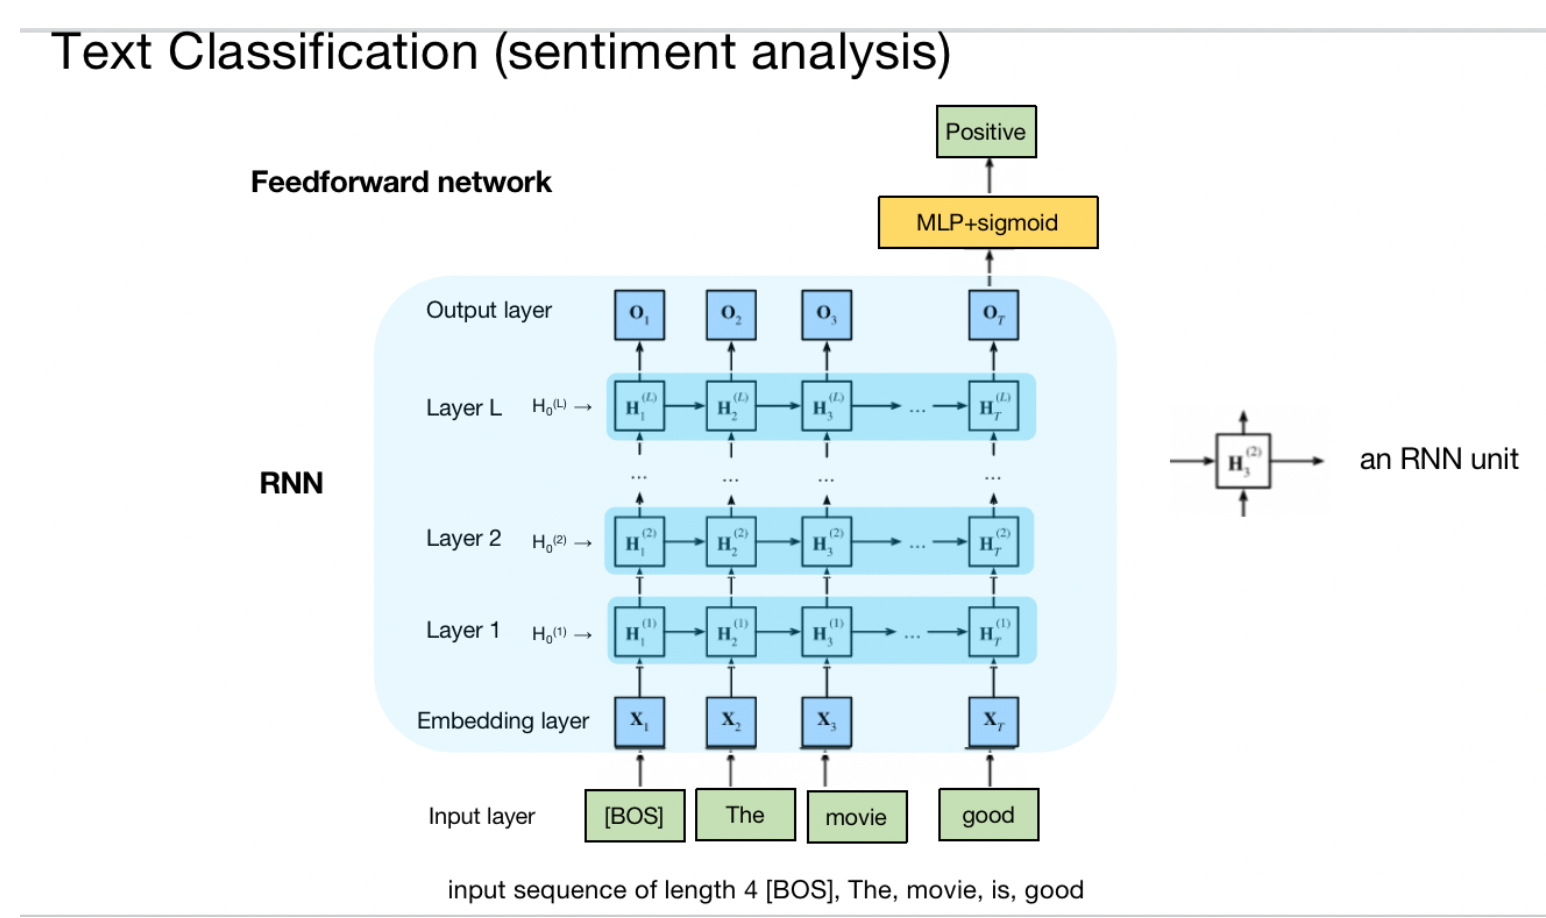

### preprocessing

In [7]:
text_to_nlp = en_core_web_md.load(disable=["parser", "tagger", "ner"])

def tokenize_spacy(text):
    return [token.text for token in text_to_nlp(text)]

class DataFrameDataset(Dataset):
    def __init__(self, df, text_field, label_field):
        self.df = df
        self.text_field = text_field
        self.label_field = label_field

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = tokenize_spacy(row['text'])
        label = row['is_good']
        return text, label


def build_vocab(iterator, max_size=25_000):
    counter = Counter()
    for tokens, labels in iterator:
        counter.update(tokens)
    vocab = Vocab(counter.most_common(max_size))

    # Define special symbols and indices
    UNK_IDX, PAD_IDX = 0, 1
    vocab = {token: i+2 for i, (token, count) in enumerate(vocab.vocab)}
    vocab['<unk>'] = UNK_IDX
    vocab['<pad>'] = PAD_IDX

    return vocab 


# Define text and label fields
text_field = tokenize_spacy
label_field = lambda x: x

# create dataset from dataframe 
all_ds = DataFrameDataset(all_data, text_field, label_field)

# Split dataset into train, valid, and test sets
train_len, valid_len = int(0.64 * len(all_ds)), int(0.16 * len(all_ds))
test_len = len(all_ds) - train_len - valid_len
train_iter, valid_iter, test_iter = random_split(all_ds, [train_len, valid_len, test_len])


# Build vocabulary
vocab = build_vocab(train_iter)


def collate_fn(batch: List[Tuple[str, str]]):
    """
    Tokenization, Numericalization, and Add UNK/PAD to create tensor for texts and labels

    sort the sequences based on their lengths first, we can ensure that shorter sequences are processed together, 
    and then pad them to match the length of the longest sequence in the batch,
    reducing the number of unnecessary padding tokens that the model has to process, 
    lead to a more efficient computation and potentially better results, 

    batch: a list of tuples, where each tuple contains a pair of text (string) and label (bool). 
            [
              ("This is a source sentence.", True),
              ("Another source sentence.", False),
              ...
            ]
    """
    texts, labels = zip(*batch)
   
    # Sort texts and labels based on the length of texts in descending order
    sorted_indices = sorted(range(len(texts)), key=lambda i: len(texts[i]), reverse=True)
    texts = [texts[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]
    
    # Convert texts to indices using the vocabulary
    texts = [[vocab[token] if token in vocab else vocab['<unk>'] for token in text] for text in texts]
    
    # Convert texts and labels to tensors
    texts = [torch.tensor(text, dtype=torch.long) for text in texts]
    labels = torch.tensor(labels, dtype=torch.float)
    
    # Pad sequences
    texts = pad_sequence(texts, padding_value=vocab['<pad>'], batch_first=True)
    
    return texts, labels

# Define DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_loader = DataLoader(valid_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)


/usr/local/lib/python3.9/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [78]:
# display first entry; this should be the text of the review followed by a binary sentiment classification
print(all_ds[0])

(['A', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.'], False)


In [8]:
print(f"Unique tokens in vocabulary: {len(vocab)}")
# See how many examples there are in each subset
print(f'Number of training examples: {len(train_iter)}')
print(f'Number of validation examples: {len(valid_iter)}')
print(f'Number of testing examples: {len(test_iter)}')

Unique tokens in vocabulary: 13619
Number of training examples: 5458
Number of validation examples: 1364
Number of testing examples: 1707


### Model

#### SRN


Now that you've set everything up, you're ready to build the network architecture.

**Step 1**: The first thing you’ll want to do is fill out the code in the initialization of the RNN class. 

You’ll need to define three layers: `self.embedding`, `self.rnn`, and `self.fc`. 

Use the built-in functions in `torch.nn` to accomplish this.

use `torch.nn.RNN` for SRN and set `batch_first=True`

a fully-connected layer is a linear layer. **input is hidden state of final time step of final RNN layer, output a logit. apply sigmoid to get probability score between 0 and 1. if probability > 0.5, sentiment is positive, else negative.**

we don't apply sigmoid in network but in loss function `torch.nn.BCEWithLogitsLoss()` and accuracy function `binary_accuracy()`

 and pay attention to what each dimensions each layer should have for its input and output.

**Step 2**: The next step (still in the RNN class) is to implement the forward pass. 

Make use of the layers you defined above to create embedded, hidden, and output vectors for a given input x.

Hint to start our model:
The RNN model should have the following structure:

1. start by an embedding layer; shape:  (input_dim, embedding_dim)

2. then we put the RNN layer; shape: (embedding_dim, hidden_dim)

3. last, we add a linear layer; shape: (hidden_dim, output_dim)

In [44]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

        
    def forward(self, text):
        """
        input: 
        text: (batch_size, seq_len)

        output:
        logits  (batch_size)
        """
        embed = self.embedding(text)  # (batch_size, seq_len, hidden_dim)
        output, hidden = self.rnn(embed)  # output (batch_size, seq_len, output_dim), hidden [1, seq_len, hidden_dim]
        logits = self.fc(hidden.squeeze(0)).squeeze(1)      # hidden (batch_size, output_dim)

        return logits  # (batch_size)

#### BiLSTM

modify your RNN into a bidirectional LSTM network. We should expect that this kind of model performs better than our previous ones.

1. You’ll be making changes to your model in the `RNN` Class. 

    In the `init` class, for the rnn layer, use the `nn.LSTM` function and make sure you pass in the bidirectional argument and set `batch_first=True`
    
    Also note that the fully connected layer now has to map from two hidden layer passes (forward and backward).
    
2. In the forward pass, not much changes from before, besides the addition of the cell. 

    Also note that you’ll have to concatenate the final forward hidden layer and the final backward hidden layer. 

    If any of this is unclear, look up example of how `nn.LSTM` works for clarification.

In [ ]:
class LSTM(nn.Module):
    # TODO: IMPLEMENT THIS FUNCTION
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, bidirectional=True):
        """    
        Initialize the three layers in the RNN, self.embedding, self.rnn, and self.fc
        Each one has a corresponding function in nn
        embedding maps from input_dim->embedding_dim
        rnn maps from embedding_dim->hidden_dim
        fc maps from hidden_dim*2->output_dim
        """
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)
        self.out = torch.nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        
    def forward(self, text):
        """
        x has dimensions [sentence length, batch size]
        embedded has dimensions [sentence length, batch size, embedding_dim]
        output has dimensions [sentence length, batch size, hidden_dim*2] (since bidirectional)
        hidden has dimensions [2, batch size, hidden_dim]
        cell has dimensions [2, batch_size, hidden_dim]

        return: 
        logits (batch_size)
        """
        embed = self.embedding(text)
        output, (hidden, cell) = self.rnn(embed)
        # Concatenate the final forward and backward hidden layers
        if self.rnn.bidirectional:  
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1) #hidden = [batch size, hidden dim*2]
        else:
            hidden = hidden[-1,:,:] #hidden = [batch size, hidden dim]

        logits = self.out(hidden).squeeze(1)  # [64, 1] => [64]
        return logits       


### accuracy


The model will give us outputs in the range (-Inf,Inf). Your job now is to take a list of these outputs, convert them to predictions of the sentiment label, and calculate the accuracy of the RNN classifier. To this end, fill in the code cell below to implement the `binary_accuracy` function.

Hint: you will need to use an activation function called the **sigmoid** function (`torch.sigmoid`) to get your outputs in the appropriate range, as they need to be converted to probabilities. Then you can predict the class based on whether the probability is below or above 0.5, and compare it to the ground truth label.

In [10]:
## TODO: return the accuracy given the RNN outputs (outputs) and true values (y); accuracy should be a float number
def binary_accuracy(outputs, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    outputs = torch.sigmoid(outputs)
    accuracy = torch.mean((outputs > 0.5).eq(y).float()).item()
    return accuracy

### Training function

The next function is the train function. 

Most of the code is handled for you – you only need to get a set of predictions for the current batch and then calculate the current loss and accuracy. 

For the latter two calculations, make sure to use the `criterion` and `binary_accuracy` functions you are given. 

For calculating the batch predictions, extract the text of the current batch and run it through the model, which is passed in as a parameter.

In [24]:
## TODO: finish the training function
## loader contains batches of the training data; 
## hint: use batch.text and batch.label to get access to the training data and labels
def train(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for text, labels in loader:
        text = text.to(device)
        labels = labels.to(device)
        # reset the optimiser
        optimizer.zero_grad()

        # TODO: make predictions
        outputs = model(text)
        # TODO: calculate loss and accuracy
        loss = criterion(outputs, labels) 
        acc = binary_accuracy(outputs, labels)
        # backprop
        loss.backward()
        # update params
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss / len(loader), epoch_acc / len(loader)

### Evaluation function

This step is to copy and paste what you did in the training function into the evaluate function. This time, there’s no additional optimization after the predictions, loss, and accuracy are calculated.

In [25]:
## TODO: finish the evaluation function
## loader contains batches of the training data; 
## hint: this function is very similar to the training function
def evaluate(model, loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for text, labels in loader:
            ## TODO starts
            text = text.to(device)
            labels = labels.to(device)
            # TODO: make predictions
            outputs = model(text)
            # TODO: calculate loss and accuracy
            loss = criterion(outputs, labels) 
            acc = binary_accuracy(outputs, labels)
            ## TODO ends
            epoch_loss += loss.item()
            epoch_acc += acc
            
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

### training


It may take a few minutes in total. The validation set accuracy is around 54%.

In [42]:
def train_model(model, filename, N_EPOCHS = 5):
  SAVE_DIR = 'models'

  MODEL_SAVE_PATH = os.path.join(SAVE_DIR, filename)
  if not os.path.isdir(f'{SAVE_DIR}'):
      os.makedirs(f'{SAVE_DIR}')

  # Settings
  SEED = 12138
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

  # set up learning rate + optimization algorithm
  learning_rate = 0.001
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = torch.nn.BCEWithLogitsLoss() # need the "with logits" as we need the range to be between 0 and 1

  best_valid_loss = float('inf')

  for epoch in range(N_EPOCHS):
      
      train_loss, train_acc = train(model, train_loader, optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
        
      # we keep track of the best model, and save it
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), MODEL_SAVE_PATH)
      
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  # Restore the best model and evaluate. The test accuracy should be around 55%.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))
  test_loss, test_acc = evaluate(model, test_loader, criterion)

  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [45]:
# train SRN
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
rnn = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
filename = 'RNN.pt'
train_model(rnn, filename)

/usr/local/lib/python3.9/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


	Train Loss: 0.684 | Train Acc: 57.15%
	 Val. Loss: 0.693 |  Val. Acc: 54.59%
	Train Loss: 0.680 | Train Acc: 58.68%
	 Val. Loss: 0.698 |  Val. Acc: 51.58%
	Train Loss: 0.679 | Train Acc: 58.85%
	 Val. Loss: 0.693 |  Val. Acc: 54.52%
	Train Loss: 0.676 | Train Acc: 59.07%
	 Val. Loss: 0.693 |  Val. Acc: 54.94%
	Train Loss: 0.671 | Train Acc: 59.23%
	 Val. Loss: 0.696 |  Val. Acc: 55.01%
Test Loss: 0.689 | Test Acc: 57.97%


Compare this performance to the simple model performance from Part A.

performance is worse because a simple one-layer unidirectional SRN may can't capture complex sentiment in a sentence.

In [52]:
# training BiLSTM
lstm = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
filename = 'LSTM.pt'
train_model(lstm, filename)

	Train Loss: 0.671 | Train Acc: 59.00%
	 Val. Loss: 0.669 |  Val. Acc: 60.54%
	Train Loss: 0.623 | Train Acc: 65.92%
	 Val. Loss: 0.658 |  Val. Acc: 60.80%
	Train Loss: 0.538 | Train Acc: 73.73%
	 Val. Loss: 0.678 |  Val. Acc: 62.95%
	Train Loss: 0.416 | Train Acc: 81.64%
	 Val. Loss: 0.706 |  Val. Acc: 64.53%
	Train Loss: 0.304 | Train Acc: 88.03%
	 Val. Loss: 0.749 |  Val. Acc: 66.86%
Test Loss: 0.670 | Test Acc: 59.36%


Do you think LSTM is working better than RNN? Why or why not? How do you compare with LSTM and RNN (model complexity, etc)?





LSTMs generally outperform RNNs, especially in tasks involving long-range dependencies because LSTMs address the vanishing gradient problem. 

LSTMs have increased model complexity (more gates (input, output, and forget gates) and internal states)

## Part D: BERT


In this part, we will use **pre-trained BERT model as word embedding** to improve text classification.

 You won't have to code anything for yourself here; we provide the code to serve as a learning resource.

Bidirectional Encoder Representations from Transformers (BERT) is a technique for NLP pre-training developed by Google. BERT was created and published in 2018 by Jacob Devlin and his colleagues from Google. Google is leveraging BERT to better understand user searches. (From WIKI)


Read more: http://jalammar.github.io/illustrated-transformer/

BERT paper: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

Understanding BERT: https://towardsdatascience.com/understanding-bert-is-it-a-game-changer-in-nlp-7cca943cf3ad

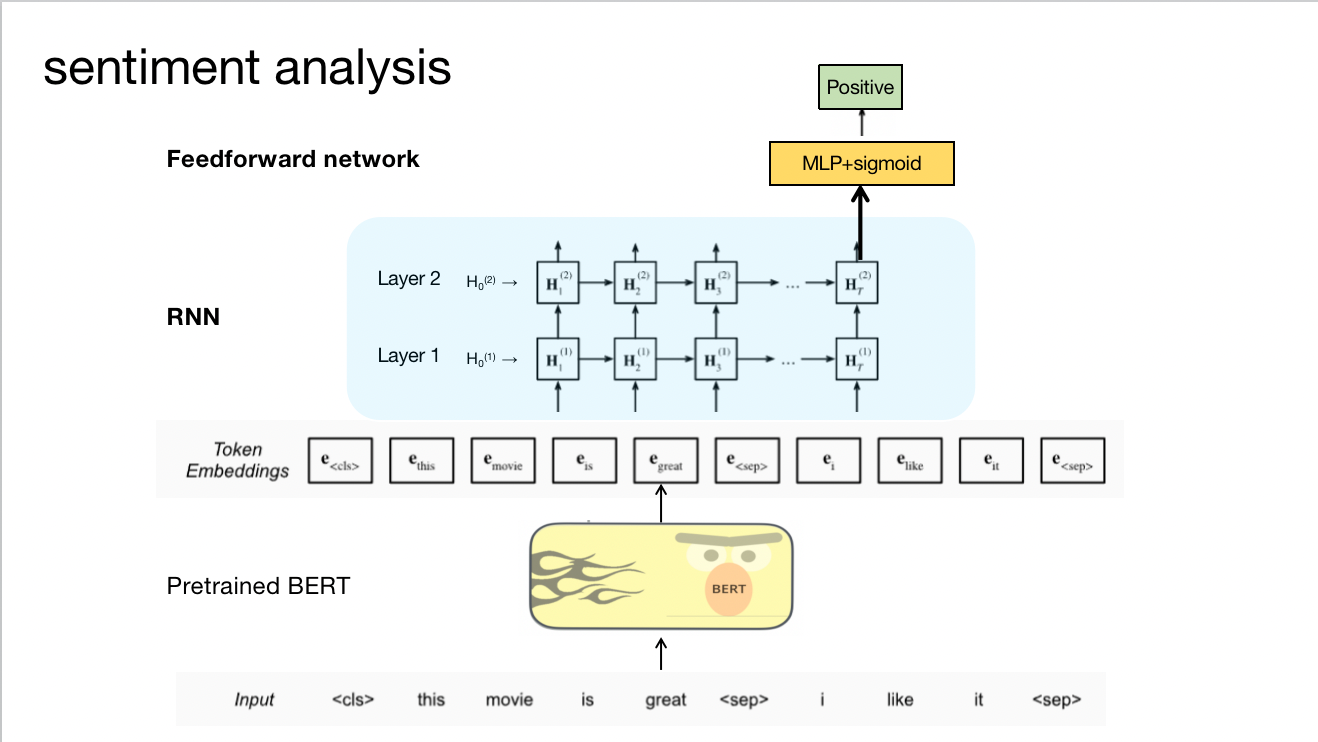

### preprocessing

In [56]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

class DataFrameDataset(Dataset):
    def __init__(self, df, text_field, label_field):
        self.df = df
        self.text_field = text_field
        self.label_field = label_field

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = self.text_field(row['text'])
        label = row['is_good']
        return text, label

# Replace custom tokenizer with BERT tokenizer
def tokenize_bert(text):
    tokens = tokenizer.tokenize(text)[:max_input_length - 2]
    return ['[CLS]'] + tokens + ['[SEP]']

# Define text and label fields
text_field = tokenize_bert
label_field = lambda x: x

# create dataset from dataframe 
all_ds = DataFrameDataset(all_data, text_field, label_field)

# Split dataset into train, valid, and test sets
train_len, valid_len = int(0.64 * len(all_ds)), int(0.16 * len(all_ds))
test_len = len(all_ds) - train_len - valid_len
train_iter, valid_iter, test_iter = random_split(all_ds, [train_len, valid_len, test_len])

# Build vocabulary from BERT tokenizer
vocab = tokenizer.get_vocab()

def collate_fn(batch):
    texts, labels = zip(*batch)

    # Sort texts and labels based on the length of texts in descending order
    sorted_indices = sorted(range(len(texts)), key=lambda i: len(texts[i]), reverse=True)
    texts = [texts[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]

    # Convert texts to indices using the vocabulary
    texts = [tokenizer.convert_tokens_to_ids(text) for text in texts]
    
    # Convert texts and labels to tensors
    texts = [torch.tensor(text, dtype=torch.long) for text in texts]
    labels = torch.tensor(labels, dtype=torch.float)

    # Pad sequences
    texts = pad_sequence(texts, padding_value=vocab['[PAD]'], batch_first=True)

    return texts, labels

# Define DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_loader = DataLoader(valid_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [55]:
# tokenize a sentence: you will see the tokenizer "cleans" the sentence as well.
tokens = tokenizer.tokenize('Hello WORLD how ARE yoU?')
print(tokens)
# Convert text to ids (positions in a dictionary)
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

['hello', 'world', 'how', 'are', 'you', '?']
[7592, 2088, 2129, 2024, 2017, 1029]


In [54]:
# Special tokens
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

# Special token ids
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

[CLS] [SEP] [PAD] [UNK]
101 102 0 100


In [67]:
# download the pre-trained BERT base model
bert = BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### BERT with RNN model

In [68]:
# Modify the RNN class to incorporate BERT representations
class BERTwithRNN(nn.Module):
    def __init__(self,bert,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        with torch.no_grad():
            embedded = self.bert(text)[0] #embedded = [batch size, sent len, emb dim]
        _, hidden = self.rnn(embedded) #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)) #hidden = [batch size, hidden dim*2]
        else:
            hidden = self.dropout(hidden[-1,:,:]) #hidden = [batch size, hidden dim]
        
        output = self.out(hidden).squeeze(1) #output = [batch size, out dim]
        
        return output

In [70]:
# Count the number of parameters in the model. The value should shock you!
def count_parameters(model):
    param_number = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return param_number

print(f'The model has {count_parameters(bert_model):,} trainable parameters')

The model has 112,241,409 trainable parameters


### training

In [ ]:

HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

bert_model = BERTwithRNN(bert,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT).to(device)

# fix the bert embeddings
for name, param in bert_model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

filename = 'Bert.pt'
train_model(bert_model, filename)
# Note that it will take ~17 minutes for one epoch.
# The output will be: Epoch: 01 | Epoch Time: 17m 36s...
# Validate accuracy is higher than 85% in the first epoch, higher than 90% in the second epoch.


**Question**: how do you compare the bert model with Part B? (Hint: consider training time, accuracy, model complexity etc.)

**TODO: write your answer here**